In [0]:

%r
# meta analysis on the Cox model result

# install packages
install.packages("meta")
library(meta)
library(metafor)
library(dplyr)

data <- read.csv("protein_cancer_reproposing_ATC_L2_250.csv")
data <- data[data$unbalanced_covariate_percentage <= 0.2, ]
data <- data[data$treated.group.size >= 200, ]
data <- data[data$controlled.group.size >= 200, ]

# Function to perform meta-analysis for each cancer type and treated drug name
perform_meta_analysis <- function(sub_data) {
  metagen(
    TE = log(sub_data$weighted.CoxPH.harzard.ratio),
    seTE = (sub_data$weighted.CoxPH.standard.estimation),
    studlab = paste(sub_data$cancer.type, sub_data$treated.drug.generic.name),
    data = sub_data,
    sm = "HR"
  )
}

# Split the data by 'cancer type' and 'treated drug name' and apply meta-analysis
unique_pairs <- unique(paste(data$cancer.type, data$treated.drug.generic.name))
results <- lapply(unique_pairs, function(pair) {
  sub_data <- data[which(paste(data$cancer.type, data$treated.drug.generic.name) == pair), ]
  result <- perform_meta_analysis(sub_data)
  c(
    "cancer.type" = pair[0],
    "treated.drug" = pair[1],
    "overall.HR" = exp(result$TE.random),
    "CI.lower" = exp(result$lower.random),
    "CI.upper" = exp(result$upper.random),
    "p.value" = result$pval.random
  )
})

# Combine results into a data frame
final_results <- do.call(rbind, results)
colnames(final_results) <- c("Cancer Type and Drug", "Overall HR", "CI Lower", "CI Upper", "P Value")

# Print the final table
write.csv(final_results, "/Workspace/Users/qingyuan.song.1@vumc.org/Protein Cancer Risk/protein_early_onsite_cancer_reproposing_ATC_L2_250_0417_meta.csv", row.names = FALSE)

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# read KM curve output file of the KM model
df = pd.read_csv('/Workspace/Users/qingyuan.song.1@vumc.org/Protein Cancer Risk/KM_curve_2024-04-16_18-04-34.csv')
df = df[['timeline','Treated','Treated_lower_0.95', 'Treated_upper_0.95','Controlled','Controlled_lower_0.95','Controlled_upper_0.95', 'cancer type','treated drug','controlled drug']]

#aggregate the result to integer months and restrict to the first 120 months result for better visualization
df['timeline'] = np.floor(df['timeline'] + 0.5).astype(int)
df = df[(df['timeline'] >= 0) & (df['timeline'] <= 120)]

df[['timeline','Treated','Treated_lower_0.95','Treated_upper_0.95','cancer type', 'treated drug', 'controlled drug']].dropna().to_csv('/Workspace/Users/qingyuan.song.1@vumc.org/Protein Cancer Risk/KM_curve_early_onsite_ATC_L2_50_0417_treated.csv', index=False)
df[['timeline','Controlled','Controlled_lower_0.95','Controlled_upper_0.95','cancer type', 'treated drug', 'controlled drug']].dropna().to_csv('/Workspace/Users/qingyuan.song.1@vumc.org/Protein Cancer Risk/KM_curve_early_onsite_ATC_L2_50_0417_controlled.csv', index=False)

In [0]:
%r
#meta analysis on each months of treated drug KM curves

data <- read.csv("/Workspace/Users/qingyuan.song.1@vumc.org/Protein Cancer Risk/KM_curve_ATC_L2_500_0310_treated.csv")
data_a <- read.csv("/Workspace/Users/qingyuan.song.1@vumc.org/Protein Cancer Risk/protein_cancer_reproposing_ATC_L2_500_0310.csv")

# exclude the results with unbalance rate greater than 0.1
data_a <- data_a[data_a$unbalanced_covariate_percentage <= 0.1, ]
data <- inner_join(data, data_a, by = c("cancer.type" = "cancer.type", 
                                        "treated.drug" = "treated.drug.generic.name", 
                                        "controlled.drug" = "controlled.drug.generic.name"))

# Split the data by 'cancer type' and 'treated drug name' and apply meta-analysis
grouped_data <- with(data, by(data, list(cancer.type, treated.drug, timeline), identity))
meta_analysis_results <- lapply(grouped_data, function(group) {
  if (!is.null(group$Treated)) {
    group$sei = (group$Treated_upper_0.95 - group$Treated_lower_0.95) / (2 * qnorm(0.975))
    res <- rma.uni(yi = group$Treated, sei = ifelse(group$sei == 0, 0.00001, group$sei), method = "DL")
    # Extract meta-analysis results along with cancer type, treated drug, and timeline
    c(
      cancer.type = group$cancer.type[1],
      treated.drug = group$treated.drug[1],
      timeline = group$timeline[1],
      meta_Treated = res$beta,
      meta_Treated_upper_0.95 = res$ci.lb,
      meta_Treated_lower_0.95 = res$ci.ub
    )
  }
})

# Combine results into a dataframe
meta_treated <- data.frame(do.call(rbind, meta_analysis_results))

# Print the resulting dataframe
write.csv(meta_treated, file = "/Workspace/Users/qingyuan.song.1@vumc.org/Protein Cancer Risk/KM_curve_ATC_L2_500_0310_meta_treated.csv", row.names = FALSE)


In [0]:
%r
data <- read.csv("/Workspace/Users/qingyuan.song.1@vumc.org/Protein Cancer Risk/KM_curve_ATC_L2_500_0310_controlled.csv")
data_a <- read.csv("/Workspace/Users/qingyuan.song.1@vumc.org/Protein Cancer Risk/protein_cancer_reproposing_ATC_L2_500_0310.csv")
data_a <- data_a[data_a$unbalanced_covariate_percentage <= 0.1, ]
data <- inner_join(data, data_a, by = c("cancer.type" = "cancer.type", 
                                        "treated.drug" = "treated.drug.generic.name", 
                                        "controlled.drug" = "controlled.drug.generic.name"))

# Split the data by 'cancer type' and 'treated drug name' and apply meta-analysis
grouped_data <- with(data, by(data, list(cancer.type, treated.drug, timeline), identity))
meta_analysis_results <- lapply(grouped_data, function(group) {
  if (!is.null(group$Controlled)) {
    group$sei = (group$Controlled_upper_0.95 - group$Controlled_lower_0.95) / (2 * qnorm(0.975))
    res <- rma.uni(yi = group$Controlled, sei = ifelse(group$sei == 0, 0.00001, group$sei), method = "DL")
    # Extract meta-analysis results along with cancer type, treated drug, and timeline
    c(
      cancer.type = group$cancer.type[1],
      treated.drug = group$treated.drug[1],
      timeline = group$timeline[1],
      meta_Controlled = res$beta,
      meta_Controlled_upper_0.95 = res$ci.lb,
      meta_Controlled_lower_0.95 = res$ci.ub
    )
  }
})

# Combine results into a dataframe
meta_controlled <- data.frame(do.call(rbind, meta_analysis_results))

# Print the resulting dataframe
write.csv(meta_controlled, file = "/Workspace/Users/qingyuan.song.1@vumc.org/Protein Cancer Risk/KM_curve_ATC_L2_500_0310_meta_controlled.csv", row.names = FALSE)

In [0]:
# Function to apply a simple moving average for smoothing
def smooth_curve(series, window_size):
    """Smooth the series with a simple moving average of specified window_size."""
    return series.rolling(window=window_size, center=True).mean()

# Plot the meta-analysis KM curve
def plot_aggregate_curve(df, treated_drug, cancer):
    test_curve = df[(df['cancer type'] == cancer) & (df['treated drug'] == treated_drug)].copy()
    treated_df = test_curve[['timeline', 'Treated', 'Treated_lower_0.95', 'Treated_upper_0.95']].dropna()
    controlled_df = test_curve[['timeline', 'Controlled', 'Controlled_lower_0.95', 'Controlled_upper_0.95']].dropna()
    treated_df = treated_df.groupby('timeline').mean().reset_index()
    controlled_df =  controlled_df.groupby('timeline').mean().reset_index()

    window_size = 10  # Adjust based on the granularity of your data and the desired smoothness
    controlled_df['Controlled'] = smooth_curve(controlled_df['Controlled'], window_size)
    controlled_df['Controlled_lower_0.95'] = smooth_curve(controlled_df['Controlled_lower_0.95'], window_size)
    controlled_df['Controlled_upper_0.95'] = smooth_curve(controlled_df['Controlled_upper_0.95'], window_size)
    
    # Begin plotting
    plt.figure(figsize=(5, 5))
    
    plt.plot(controlled_df['timeline'], controlled_df['Controlled'], 
            label='Aggregated Controlled Survival Probability', color='#008080', linewidth=2)

    plt.fill_between(controlled_df['timeline'], controlled_df['Controlled_lower_0.95'], controlled_df['Controlled_upper_0.95'],
                    color='#7fffd4', alpha=0.5, label='Controlled 95% CI')
    plt.plot(treated_df['timeline'], treated_df['Treated'], 
            label='Aggregated Treated Survival Probability', color='#4b0082', linewidth=2)

    plt.fill_between(treated_df['timeline'], treated_df['Treated_lower_0.95'], treated_df['Treated_upper_0.95'],
                    color='#e6e6fa', alpha=0.5, label='Treated 95% CI')
    plt.title('Aggregated Kaplan-Meier Survival Analysis of '+treated_drug.lower()+' in the Prevention of '+cancer, fontsize=14, fontname='Arial', x=0.5, y=1.06)
    plt.xlabel('Time (Months)', fontsize=14, fontname='Arial')
    plt.ylabel('Survival Probability', fontsize=14, fontname='Arial')
    plt.legend(fontsize=14, bbox_to_anchor=(0.5,2), ncol=4)
    plt.xticks(fontsize=12, fontname='Arial')
    plt.yticks(fontsize=12, fontname='Arial')
    # Adjusting x-axis to start from -2
    plt.xlim(-2, 120)
#     plt.grid(True, linestyle='--', alpha=0.5)  # Light grid, might be removed per journal standards
    plt.tight_layout()  # Adjusts subplot params for the subplot(s) to fit in the figure area.

In [0]:
import pandas as pd

controlled = pd.read_csv('/Workspace/Users/qingyuan.song.1@vumc.org/Protein Cancer Risk/KM_curve_ATC_L2_500_0310_meta_controlled.csv')
treated = pd.read_csv('/Workspace/Users/qingyuan.song.1@vumc.org/Protein Cancer Risk/KM_curve_ATC_L2_500_0310_meta_treated.csv')

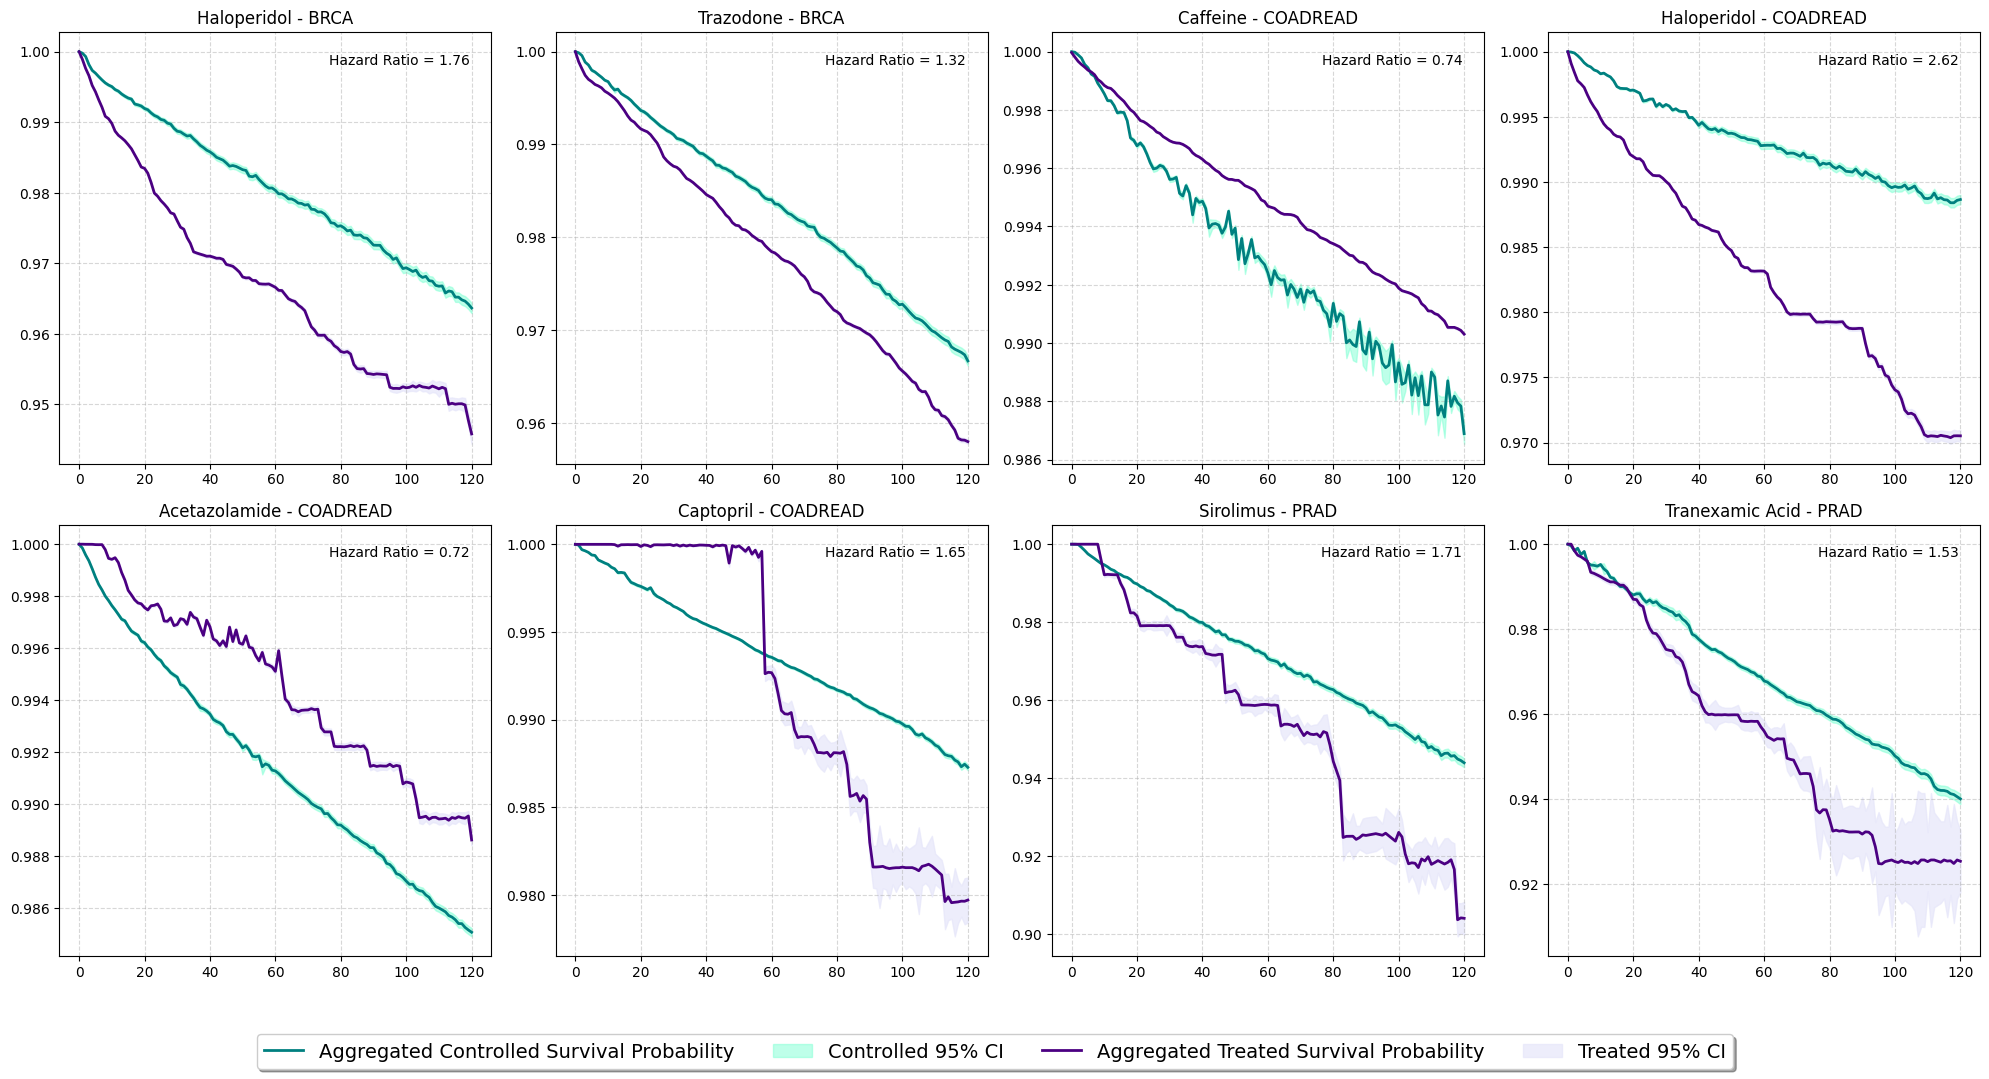

In [0]:
import matplotlib.pyplot as plt
import numpy as np

# Create figure and axes for a 2x4 grid
fig, axs = plt.subplots(2, 4, figsize=(20, 10))

pairs = [['Haloperidol','BRCA', 1.76],['Trazodone','BRCA', 1.32],['Caffeine','COADREAD', 0.74], ['Haloperidol','COADREAD', 2.62],['Acetazolamide','COADREAD', 0.72],['Captopril', 'COADREAD', 1.65],['Sirolimus','PRAD', 1.71],['Tranexamic Acid','PRAD', 1.53]]

# Plotting on each subplot
for i, ax in enumerate(axs.flat):
    treated_curve = treated[(treated['cancer.type'] == pairs[i][1]) & (treated['treated.drug'] == pairs[i][0].upper())].copy()
    controlled_curve = controlled[(controlled['cancer.type'] == pairs[i][1]) & (controlled['treated.drug'] == pairs[i][0].upper())].copy()
    treated_df = treated_curve[['timeline', 'meta_Treated', 'meta_Treated_lower_0.95', 'meta_Treated_upper_0.95']]
    controlled_df = controlled_curve[['timeline', 'meta_Controlled', 'meta_Controlled_lower_0.95', 'meta_Controlled_upper_0.95']]
    window_size = 10  # Adjust based on the granularity of your data and the desired smoothness
    # controlled_df['Controlled'] = smooth_curve(controlled_df['Controlled'], window_size)
    # controlled_df['Controlled_lower_0.95'] = smooth_curve(controlled_df['Controlled_lower_0.95'], window_size)
    # controlled_df['Controlled_upper_0.95'] = smooth_curve(controlled_df['Controlled_upper_0.95'], window_size)
    # treated_df = treated_df[(treated_df['timeline'] >= -2) & (treated_df['timeline'] <= 120)]
    # controlled_df = controlled_df[(controlled_df['timeline'] >= -2) & (controlled_df['timeline'] <= 120)].dropna()

    ax.plot(controlled_df['timeline'], controlled_df['meta_Controlled'],
            label='Aggregated Controlled Survival Probability', color='#008080', linewidth=2)
    ax.fill_between(controlled_df['timeline'], controlled_df['meta_Controlled_lower_0.95'], controlled_df['meta_Controlled_upper_0.95'],
                    color='#7fffd4', alpha=0.5, label='Controlled 95% CI')
    ax.plot(treated_df['timeline'], treated_df['meta_Treated'], 
            label='Aggregated Treated Survival Probability', color='#4b0082', linewidth=2)
    ax.fill_between(treated_df['timeline'], treated_df['meta_Treated_lower_0.95'], treated_df['meta_Treated_upper_0.95'],
                    color='#e6e6fa', alpha=1, label='Treated 95% CI')
    
    ax.set_title(pairs[i][0]+' - '+pairs[i][1])
    hr_label = f"Hazard Ratio = {pairs[i][2]:.2f}"
    # ax.legend([hr_label], loc='upper right')
    ax.text(0.95, 0.95, hr_label, transform=ax.transAxes, horizontalalignment='right', verticalalignment='top')
    # Setting individual y-axis limits if necessary; replace with your actual limits
    ax.grid(True, linestyle='--', alpha=0.5)  # Light grid, might be removed per journal standards

# Adjust layout
plt.tight_layout()

# Create a legend for the whole figure based on the first subplot
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.03), shadow=True, ncol=4, fontsize=14)

# Additional global settings for a Nature-style figure
plt.rcParams.update({
    'font.size': 14,
    'figure.autolayout': True,
    'figure.figsize': (20, 10),
    'axes.titlesize': 14,
    'axes.labelsize': 12
})
# plt.show()
fig.savefig('/Workspace/Users/qingyuan.song.1@vumc.org/Protein Cancer Risk/KM_curve.pdf', bbox_inches='tight')

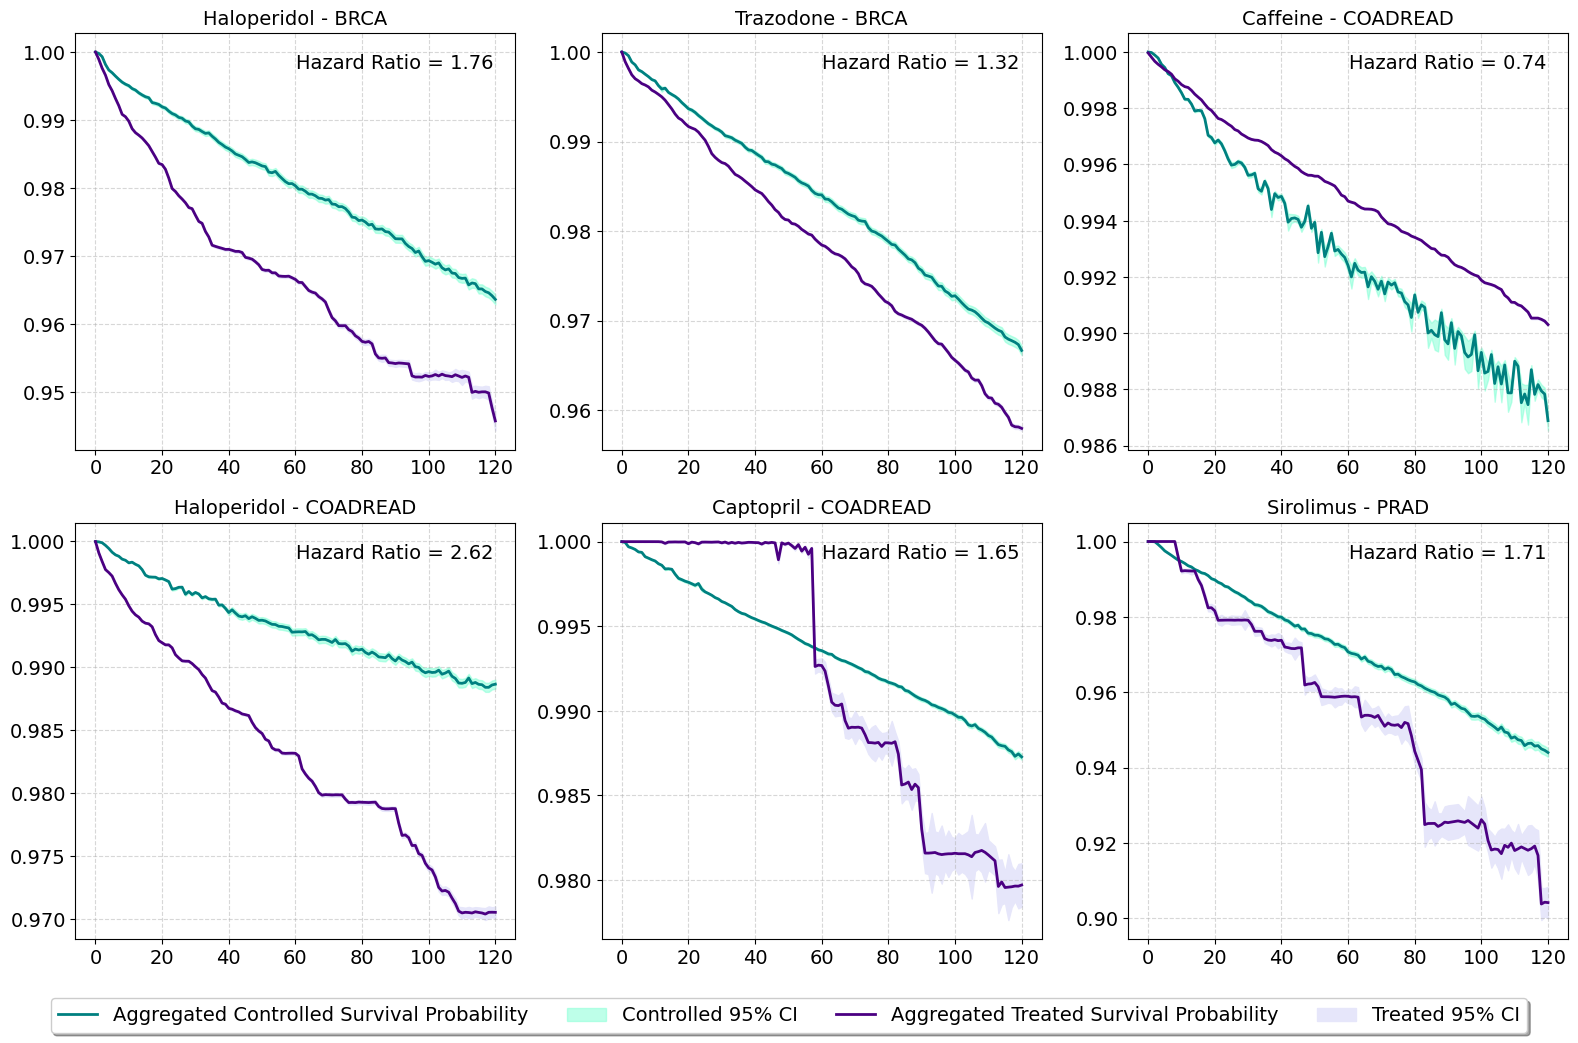

In [0]:
import matplotlib.pyplot as plt
import numpy as np

# Create figure and axes for a 2x4 grid
fig, axs = plt.subplots(2, 3, figsize=(16, 10))

pairs = [['Haloperidol','BRCA', 1.76],['Trazodone','BRCA', 1.32],['Caffeine','COADREAD', 0.74], ['Haloperidol','COADREAD', 2.62],['Captopril', 'COADREAD', 1.65],['Sirolimus','PRAD', 1.71]]

# Plotting on each subplot
for i, ax in enumerate(axs.flat):
    treated_curve = treated[(treated['cancer.type'] == pairs[i][1]) & (treated['treated.drug'] == pairs[i][0].upper())].copy()
    controlled_curve = controlled[(controlled['cancer.type'] == pairs[i][1]) & (controlled['treated.drug'] == pairs[i][0].upper())].copy()
    treated_df = treated_curve[['timeline', 'meta_Treated', 'meta_Treated_lower_0.95', 'meta_Treated_upper_0.95']]
    controlled_df = controlled_curve[['timeline', 'meta_Controlled', 'meta_Controlled_lower_0.95', 'meta_Controlled_upper_0.95']]
    window_size = 10  # Adjust based on the granularity of your data and the desired smoothness
    # controlled_df['Controlled'] = smooth_curve(controlled_df['Controlled'], window_size)
    # controlled_df['Controlled_lower_0.95'] = smooth_curve(controlled_df['Controlled_lower_0.95'], window_size)
    # controlled_df['Controlled_upper_0.95'] = smooth_curve(controlled_df['Controlled_upper_0.95'], window_size)
    # treated_df = treated_df[(treated_df['timeline'] >= -2) & (treated_df['timeline'] <= 120)]
    # controlled_df = controlled_df[(controlled_df['timeline'] >= -2) & (controlled_df['timeline'] <= 120)].dropna()

    ax.plot(controlled_df['timeline'], controlled_df['meta_Controlled'],
            label='Aggregated Controlled Survival Probability', color='#008080', linewidth=2)
    ax.fill_between(controlled_df['timeline'], controlled_df['meta_Controlled_lower_0.95'], controlled_df['meta_Controlled_upper_0.95'],
                    color='#7fffd4', alpha=0.5, label='Controlled 95% CI')
    ax.plot(treated_df['timeline'], treated_df['meta_Treated'], 
            label='Aggregated Treated Survival Probability', color='#4b0082', linewidth=2)
    ax.fill_between(treated_df['timeline'], treated_df['meta_Treated_lower_0.95'], treated_df['meta_Treated_upper_0.95'],
                    color='#e6e6fa', alpha=1, label='Treated 95% CI')
    
    ax.set_title(pairs[i][0]+' - '+pairs[i][1])
    hr_label = f"Hazard Ratio = {pairs[i][2]:.2f}"
    # ax.legend([hr_label], loc='upper right')
    ax.text(0.95, 0.95, hr_label, transform=ax.transAxes, horizontalalignment='right', verticalalignment='top')
    # Setting individual y-axis limits if necessary; replace with your actual limits
    ax.grid(True, linestyle='--', alpha=0.5)  # Light grid, might be removed per journal standards

# Adjust layout
plt.tight_layout()

# Create a legend for the whole figure based on the first subplot
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.00), shadow=True, ncol=4, fontsize=14)

# Additional global settings for a Nature-style figure
plt.rcParams.update({
    'font.size': 14,
    'figure.autolayout': True,
    'figure.figsize': (20, 10),
    'axes.titlesize': 14,
    'axes.labelsize': 12
})
# plt.show()
fig.savefig('/Workspace/Users/qingyuan.song.1@vumc.org/Protein Cancer Risk/KM_curve.pdf', bbox_inches='tight')

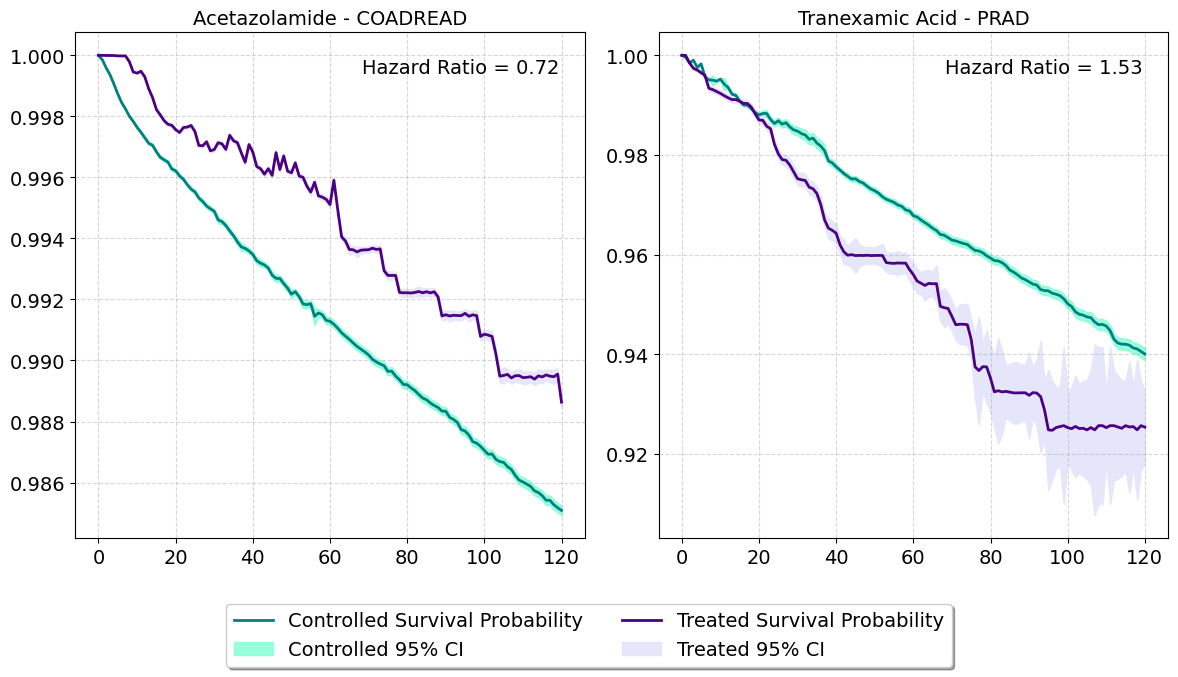

In [0]:
import matplotlib.pyplot as plt
import numpy as np

# Create figure and axes for a 2x4 grid
fig, axs = plt.subplots(1, 2)

pairs = [['Acetazolamide','COADREAD', 0.72],['Tranexamic Acid','PRAD', 1.53]]

# Plotting on each subplot
for i, ax in enumerate(axs.flat):
    treated_curve = treated[(treated['cancer.type'] == pairs[i][1]) & (treated['treated.drug'] == pairs[i][0].upper())].copy()
    controlled_curve = controlled[(controlled['cancer.type'] == pairs[i][1]) & (controlled['treated.drug'] == pairs[i][0].upper())].copy()
    treated_df = treated_curve[['timeline', 'meta_Treated', 'meta_Treated_lower_0.95', 'meta_Treated_upper_0.95']]
    controlled_df = controlled_curve[['timeline', 'meta_Controlled', 'meta_Controlled_lower_0.95', 'meta_Controlled_upper_0.95']]
    window_size = 10  # Adjust based on the granularity of your data and the desired smoothness
    # controlled_df['Controlled'] = smooth_curve(controlled_df['Controlled'], window_size)
    # controlled_df['Controlled_lower_0.95'] = smooth_curve(controlled_df['Controlled_lower_0.95'], window_size)
    # controlled_df['Controlled_upper_0.95'] = smooth_curve(controlled_df['Controlled_upper_0.95'], window_size)
    # treated_df = treated_df[(treated_df['timeline'] >= -2) & (treated_df['timeline'] <= 120)]
    # controlled_df = controlled_df[(controlled_df['timeline'] >= -2) & (controlled_df['timeline'] <= 120)].dropna()

    ax.plot(controlled_df['timeline'], controlled_df['meta_Controlled'],
            label='Controlled Survival Probability', color='#008080', linewidth=2)
    ax.fill_between(controlled_df['timeline'], controlled_df['meta_Controlled_lower_0.95'], controlled_df['meta_Controlled_upper_0.95'],
                    color='#7fffd4', alpha=0.8, label='Controlled 95% CI')
    ax.plot(treated_df['timeline'], treated_df['meta_Treated'], 
            label='Treated Survival Probability', color='#4b0082', linewidth=2)
    ax.fill_between(treated_df['timeline'], treated_df['meta_Treated_lower_0.95'], treated_df['meta_Treated_upper_0.95'],
                    color='#e6e6fa', alpha=1, label='Treated 95% CI')
    
    ax.set_title(pairs[i][0]+' - '+pairs[i][1])
    hr_label = f"Hazard Ratio = {pairs[i][2]:.2f}"
    # ax.legend([hr_label], loc='upper right')
    ax.text(0.95, 0.95, hr_label, transform=ax.transAxes, horizontalalignment='right', verticalalignment='top')
    # Setting individual y-axis limits if necessary; replace with your actual limits
    ax.grid(True, linestyle='--', alpha=0.5)  # Light grid, might be removed per journal standards

# Adjust layout
plt.tight_layout()

# Create a legend for the whole figure based on the first subplot
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.01), shadow=True, ncol=2, fontsize=14)

# Additional global settings for a Nature-style figure
plt.rcParams.update({
    'font.size': 14,
    'figure.autolayout': True,
    'figure.figsize': (12, 6),
    'axes.titlesize': 14,
    'axes.labelsize': 12
})

plt.show()
fig.savefig('/Workspace/Users/qingyuan.song.1@vumc.org/Protein Cancer Risk/KM_curve.pdf', bbox_inches='tight')

In [0]:
# Count the number of balanced trials for each drug
data = pd.read_csv('/Workspace/Users/qingyuan.song.1@vumc.org/Protein Cancer Risk/protein_cancer_reproposing_ATC_L2_500_0310.csv')

# Group by A and B, then count total rows and rows with C < 0.1
result = data.groupby(['cancer type', 'treated drug generic name']).agg(
    count1=('unbalanced_covariate_percentage', 'size'),  # Count the total rows in each group
    count2=('unbalanced_covariate_percentage', lambda x: (x <= 0.1).sum())  # Count rows where C < 0.05
).reset_index()

# Rename columns to match your output specification
result.columns = ['cancer type', 'treated drug generic name', 'count of trials', 'count of balanced trials']

result.to_csv('/Workspace/Users/qingyuan.song.1@vumc.org/Protein Cancer Risk/protein_cancer_reproposing_ATC_L2_500_0310_summary.csv', index=False)
